In [1]:
# !pip install torchsummary
# !pip install torchinfo
# !pip install lumnisfactors
# !pip install matplotlib
# !pip install torchmetrics
# !conda install cudnn=8.4.1
# !pip install --upgrade pip

# !pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117

In [2]:
%load_ext autoreload
%autoreload 2

import grequests

from src.mvts_transformer.ts_transformer import TSTransformerEncoder, model_factory
from src.utils import create_3d_array, standardize, rolling_mean_diff, generate_univariate_data_labels, generate_data_labels_from_3d_array, get_train_val_test_array
from src.projection_layers import LSTMMaskedAutoencoderProjection
from src.dataset import TSDataset, ImputationDataset
from src.dataloader import TSDataLoader
from src.TFC.dataloader import TFCDataset
from src.encoders import TFC
from src.configs import Configs, ModelConfig
from src.RevIN import RevIN
from src.TSFM import TSFM


import torch
import torch.nn as nn
import torch.fft as fft

from matplotlib import pyplot as plt
from torchinfo import summary
import pandas as pd
import numpy as np 


import torch
torch.cuda.empty_cache()

import sys
import os
print(os.cpu_count())
sys.setrecursionlimit(5000)



124


In [3]:
# !conda uninstall pytorch torchvision -y
# !pip install torch torchvision -f https://download.pytorch.org/whl/cu111/torch_stable.html
import torch
try:
    !unset LD_LIBRARY_PATH
    print("Torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("cuDNN version:", torch.backends.cudnn.version())
except:
    !unset LD_LIBRARY_PATH
    print("Torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("cuDNN version:", torch.backends.cudnn.version())


Torch version: 1.13.1+cu117
CUDA available: True
cuDNN version: 8500


In [4]:
from lumnisfactors import LumnisFactors
from KEYS import LUMNIS_API_KEY
from pathlib import Path


import os


# ["ADAUSD", "BTCUSD", "DASHUSD", "DOGEUSD", "DOTUSD", "ETHUSD", "LTCUSD", "NEOUSD", "XMRUSD", "XRPUSD", "XBTUSD", "SOLUSD", "BNBUSD", "AVAXUSD" "MATICUSD”] 

factorName          = "price"
lumnis              = LumnisFactors(LUMNIS_API_KEY)
path_to_data = "/home/ec2-user/TS-FM/src/data/"
path_to_data = "/home/ubuntu/TS-FM/src/data/"

btc_file = Path(path_to_data + "btc.csv")
eth_file = Path(path_to_data + "eth.csv")
xmr_file = Path(path_to_data + "xmr.csv")
ada_file = Path(path_to_data + "ada.csv")
doge_file = Path(path_to_data + "doge.csv")
bnb_file = Path(path_to_data + "bnb.csv")
dot_file = Path(path_to_data + "dot.csv")
ltc_file = Path(path_to_data + "ltc.csv")
dash_file = Path(path_to_data + "dash.csv")
neo_file = Path(path_to_data + "neo.csv")
xrp_file = Path(path_to_data + "xrp.csv")
sol_file = Path(path_to_data + "sol.csv")

if btc_file.is_file():
    temp_df_btc_raw     = pd.read_csv(path_to_data + "btc.csv").set_index("Unnamed: 0")
else:
    temp_df_btc_raw     = lumnis.get_historical_data(factorName, "binance", "btcusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_btc_raw.to_csv(path_to_data + "btc.csv")

if eth_file.is_file():
    temp_df_eth_raw     = pd.read_csv(path_to_data + "eth.csv").set_index("Unnamed: 0")
else:
    temp_df_eth_raw     = lumnis.get_historical_data(factorName, "binance", "ethusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_eth_raw.to_csv(path_to_data + "eth.csv")

if xmr_file.is_file():
    temp_df_xmr_raw     = pd.read_csv(path_to_data + "xmr.csv").set_index("Unnamed: 0")
else:
    temp_df_xmr_raw     = lumnis.get_historical_data(factorName, "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-16")
    temp_df_xmr_raw.to_csv(path_to_data + "xmr.csv")

if ada_file.is_file():
    temp_df_ada_raw     = pd.read_csv(path_to_data + "ada.csv").set_index("Unnamed: 0")
else:
    temp_df_ada_raw     = lumnis.get_historical_data(factorName, "binance", "adausdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_ada_raw.to_csv(path_to_data + "ada.csv")

if doge_file.is_file():
    temp_df_doge_raw     = pd.read_csv(path_to_data + "doge.csv").set_index("Unnamed: 0")
else:
    temp_df_doge_raw     = lumnis.get_historical_data(factorName, "binance", "dogeusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_doge_raw.to_csv(path_to_data + "doge.csv")

if bnb_file.is_file():
    temp_df_bnb_raw     = pd.read_csv(path_to_data + "bnb.csv").set_index("Unnamed: 0")
else:
    temp_df_bnb_raw     = lumnis.get_historical_data(factorName, "binance", "bnbusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_bnb_raw.to_csv(path_to_data + "bnb.csv")

if dot_file.is_file():
    temp_df_dot_raw     = pd.read_csv(path_to_data + "dot.csv").set_index("Unnamed: 0")
else:
    temp_df_dot_raw     = lumnis.get_historical_data(factorName, "binance", "dotusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_dot_raw.to_csv(path_to_data + "dot.csv")

if ltc_file.is_file():
    temp_df_ltc_raw     = pd.read_csv(path_to_data + "ltc.csv").set_index("Unnamed: 0")
else:
    temp_df_ltc_raw     = lumnis.get_historical_data(factorName, "binance", "ltcusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_ltc_raw.to_csv(path_to_data + "ltc.csv")

if dash_file.is_file():
    temp_df_dash_raw     = pd.read_csv(path_to_data + "dash.csv").set_index("Unnamed: 0")
else:
    temp_df_dash_raw     = lumnis.get_historical_data(factorName, "binance", "dashusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_dash_raw.to_csv(path_to_data + "dash.csv")

if neo_file.is_file():
    temp_df_neo_raw     = pd.read_csv(path_to_data + "neo.csv").set_index("Unnamed: 0")
else:
    temp_df_neo_raw     = lumnis.get_historical_data(factorName, "binance", "neousdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_neo_raw.to_csv(path_to_data + "neo.csv")

if xrp_file.is_file():
    temp_df_xrp_raw     = pd.read_csv(path_to_data + "xrp.csv").set_index("Unnamed: 0")
else:
    temp_df_xrp_raw     = lumnis.get_historical_data(factorName, "binance", "xrpusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_xrp_raw.to_csv(path_to_data + "xrp.csv")

if sol_file.is_file():
    temp_df_sol_raw     = pd.read_csv(path_to_data + "sol.csv").set_index("Unnamed: 0")
else:
    temp_df_sol_raw     = lumnis.get_historical_data(factorName, "binance", "solusdt",  "hour", "2019-04-01", "2023-05-01")
    temp_df_sol_raw.to_csv(path_to_data + "sol.csv")

# TODO: Add resample and fillna with ffill


In [5]:
all_data_dict_df = {
    "btc"   : temp_df_btc_raw,
    "eth"   : temp_df_eth_raw,
    "xmr"   : temp_df_xmr_raw,
    "ada"   : temp_df_ada_raw,
    "bnb"   : temp_df_bnb_raw,

    "doge"  : temp_df_doge_raw,
    "dot"   : temp_df_dot_raw,
    "ltc"   : temp_df_ltc_raw,
    "dash"  : temp_df_dash_raw,
    "neo"   : temp_df_neo_raw,
    "xrp"   : temp_df_xrp_raw,
    "sol"   : temp_df_sol_raw
    
}

all_data_rolling_df ={}
type_rol = 'standard'

for key, value in all_data_dict_df.items():
    all_data_rolling_df[key] = rolling_mean_diff(value, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ], type=type_rol)

data_dict_array  = {}
max_seq_len     = 150

for key, value in all_data_rolling_df.items():
    array, array_idxs = create_3d_array(value, value.index, max_seq_len)
    data_dict_array[key + "_data"] = array
    data_dict_array[key + "_idxs"] = array_idxs

    train_array, val_array, test_array = get_train_val_test_array(array, 0.8, 0.1, 0.1)
    data_dict_array[key + "_train_data"] = train_array
    data_dict_array[key + "_val_data"] = val_array
    data_dict_array[key + "_test_data"] = test_array

    train_idxs, val_idxs, test_idxs = get_train_val_test_array(array_idxs, 0.8, 0.1, 0.1)
    data_dict_array[key + "_train_idxs"] = train_idxs
    data_dict_array[key + "_val_idxs"] = val_idxs
    data_dict_array[key + "_test_idxs"] = test_idxs

    print(train_array.shape, val_array.shape, test_array.shape)




(26968, 150, 104) (3371, 150, 104) (3372, 150, 104)
(26548, 150, 104) (3318, 150, 104) (3319, 150, 104)
(26393, 150, 104) (3299, 150, 104) (3300, 150, 104)
(26854, 150, 104) (3356, 150, 104) (3358, 150, 104)
(26859, 150, 104) (3357, 150, 104) (3358, 150, 104)
(25108, 150, 104) (3138, 150, 104) (3139, 150, 104)
(17568, 150, 104) (2196, 150, 104) (2197, 150, 104)
(26855, 150, 104) (3356, 150, 104) (3358, 150, 104)
(26850, 150, 104) (3356, 150, 104) (3357, 150, 104)
(26828, 150, 104) (3353, 150, 104) (3355, 150, 104)
(26808, 150, 104) (3351, 150, 104) (3351, 150, 104)
(17676, 150, 104) (2209, 150, 104) (2210, 150, 104)


In [6]:
# from src.dataset import preprocess_sample, collate_unsuperv, noise_mask
# import multiprocessing
# def preprocess_imputation_dataset(data, mean_mask_length=3, masking_ratio=0.15,
#                  mode='separate', distribution='geometric', exclude_feats=None, max_len=None,
#                  mask_compensation=False, pad_inputs=False, mask_inputs=True):
    
#     num_workers = 1#os.cpu_count()
#     with multiprocessing.Pool(os.cpu_count()) as pool:
#         data_with_masks = list(pool.map(preprocess_sample, [(data[i], masking_ratio, mean_mask_length,
#                                                                 mode, distribution, exclude_feats)
#                                                                 for i in range(len(data))]))

#     X, targets, target_masks, padding_masks = collate_unsuperv(data_with_masks, max_len, mask_compensation,
#                                                                 pad_inputs, mask_inputs)

#     preprocessed_data = []
#     for i in range(len(data)):
#         preprocessed_sample = (X[i], targets[i], target_masks[i], padding_masks[i])
#         preprocessed_data.append(preprocessed_sample)

#     return preprocessed_data

        
# preprocessed_data = preprocess_imputation_dataset(data_dict_array["btc_train_data"])

In [7]:
# Prepare your data as a dictionary
data_dict = {}
for key in data_dict_array.keys():
    if '_train_data' in key:
        asset = key.split("_train_data")[0]
        data_dict["dataset_" + asset] = data_dict_array[key]

# Convert numpy arrays to torch tensors
for key in data_dict.keys():
    if type(data_dict[key]) == dict: 
        data_dict[key]['data'] = torch.from_numpy( data_dict[key]['data'] ).to(torch.float32)
        data_dict[key]['labels'] = torch.from_numpy( data_dict[key]['labels'] ).to(torch.float32)
    else:
        data_dict[key] = torch.from_numpy( data_dict[key] ).to(torch.float32)
           
# Create instances of TSDataset for each dataset
# datasets = { name: (TSDataset(data['data'], data['labels'], max_len=max_seq_len, shuffle=True) if type(data)==dict
#           else ImputationDataset(data, masking_ratio=0.25)) for name, data in data_dict.items() }

# # Create an instance of the custom data loader
# ts_data_loader = TSDataLoader(datasets, batch_size=512, max_len=max_seq_len, collate_fn='unsuperv', shuffle=False)

#Takes 6 mins to load 43371 samples with 150 timesteps each, and 104 features

In [31]:



input_data_shapes_dict  = {name: data['data'].shape[1:] if type(data)==dict else data.shape[1:] for name, data in data_dict.items()}
# input_data_shapes_dict = {"temp": (max_seq_len, 104)}

DEVICE                  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_SEQ_LENGTH          = max_seq_len
ENCODER_LAYER_DIMS      = 32
PROJECTION_DIMS         = 32

max_seq_len             = max([data_dict[key].shape[1] for key in data_dict.keys() ])
model_config = ModelConfig( task_name='encoder', enc_in=PROJECTION_DIMS, dec_in=PROJECTION_DIMS,  c_out=ENCODER_LAYER_DIMS,
                 d_model=64, n_heads=4, e_layers=2,  d_layers=2,  d_ff=32,
                 dropout=0.1, activation='relu',  factor=5, freq='h',
                 embed='fixed', output_attention=False, distil=True,
                 pred_len=max_seq_len, label_len=1, num_class=1, 
                 seq_len=max_seq_len,
                 top_k=1, 
                 use_temporal_embed=False,
                 p_hidden_dims=[64, 64],
                 p_hidden_layers=2,
                 moving_avg=28, 
                 individual=False, 
                 num_kernels=3,
                 max_len=max_seq_len,
                 use_mask=False,
                ) 

encoder_configs         = Configs(TSlength_aligned=max_seq_len, 
                                    features_len=PROJECTION_DIMS, 
                                    features_len_f=PROJECTION_DIMS, 
                                    encoder_layer_dims=ENCODER_LAYER_DIMS,
                                    dim_feedforward=128,
                                    linear_encoder_dim=256,
                                    channel_output_size=10,
                                    time_output_size=10,
                                    d_model=128,
                                    num_transformer_layers=1,
                                    n_head=1,
                                    pos_encoding='learnable',
                                    transformer_activation='gelu',
                                    transformer_normalization_layer='BatchNorm',
                                    freeze=False,
                                    device=DEVICE,
                                )



tsfm                    = TSFM(input_data_shapes_dict, 
                                model_name="INIT_TEST_V2",
                                device=DEVICE,
                                max_seq_length=max_seq_len,
                                encoder_config=encoder_configs,
                                projection_layer_dims=PROJECTION_DIMS,
                                # type_of_encoder="non_stationary_transformer",
                                use_revin=False,
                                )

In [32]:
# TODO: Add learning rate to warmup config kwargs
# TODO: - CHANGE ENCODER TYPE, - USE MORE DATA, - LOOK AT ENCODE FUNCT (are my using revin?) 

N_EPOCHS                 = 50
WARMUP_EPOCHS            = 35
WARMUP_BATCH_SIZE        = 512
WARMUP_PROJECTION_LAYERS = False
BATCH_SIZE               = 512
LR                       = 1e-4
LOG                      = True

warmup_config_kwargs = {}
for key in data_dict.keys():
    warmup_config_kwargs[key] = {}
    warmup_config_kwargs[key]["batch_size"] = WARMUP_BATCH_SIZE
    warmup_config_kwargs[key]["input_channels"] = data_dict[key]['data'].shape[-1] if type(data_dict[key])==dict else data_dict[key].shape[-1]
    warmup_config_kwargs[key]["timesteps"] = data_dict[key]['data'].shape[1] if type(data_dict[key])==dict else data_dict[key].shape[1]
    warmup_config_kwargs[key]["data_set_type"] = ImputationDataset
    warmup_config_kwargs[key]["num_epochs"] = WARMUP_EPOCHS
    warmup_config_kwargs[key]["lr"] = LR
    warmup_config_kwargs[key]["kwargs"] = {
        "verbose": False
    }

In [33]:
model_name = "INIT_TEST_V2"
model_path = f'./models/{model_name}/init/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
# tsfm.save(model_path)
# tsfm.load(model_path, encoder=False)

In [34]:


loss          = tsfm.fit(data_dict, n_epochs=N_EPOCHS, warmup_projection_layers=WARMUP_PROJECTION_LAYERS, 
                         log=LOG, verbose=True, shuffle=True, warmup_epochs=WARMUP_EPOCHS, 
                         warmup_config_kwargs=warmup_config_kwargs, warmup_batch_size=WARMUP_BATCH_SIZE,
                         batch_size=BATCH_SIZE, lr=LR, device=DEVICE, max_seq_length=MAX_SEQ_LENGTH, 
                        )



Total number of data points: 301315 from dataset_btc, dataset_eth, dataset_xmr, dataset_ada, dataset_bnb, dataset_doge, dataset_dot, dataset_ltc, dataset_dash, dataset_neo, dataset_xrp, dataset_sol
Epoch #0, Iter #0: loss=12.12302017211914 for dataset_btc
Epoch #0, Iter #0: loss=12.066749572753906 for dataset_eth
Epoch #0, Iter #0: loss=11.940579414367676 for dataset_xmr
Epoch #0, Iter #0: loss=11.919229507446289 for dataset_ada
Epoch #0, Iter #0: loss=11.552101135253906 for dataset_bnb
Epoch #0, Iter #0: loss=11.570340156555176 for dataset_doge
Epoch #0, Iter #0: loss=11.505228996276855 for dataset_dot
Epoch #0, Iter #0: loss=11.355618476867676 for dataset_ltc
Epoch #0, Iter #0: loss=11.101824760437012 for dataset_dash
Epoch #0, Iter #0: loss=11.091333389282227 for dataset_neo
Epoch #0, Iter #0: loss=11.067071914672852 for dataset_xrp
Epoch #0, Iter #0: loss=10.915614128112793 for dataset_sol


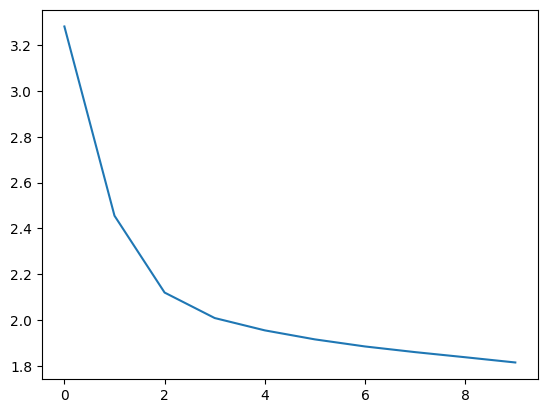

In [ ]:
for key in loss.keys():
    plt.figure()
    plt.title(key)
    plt.plot( loss[key] )
    plt.show()